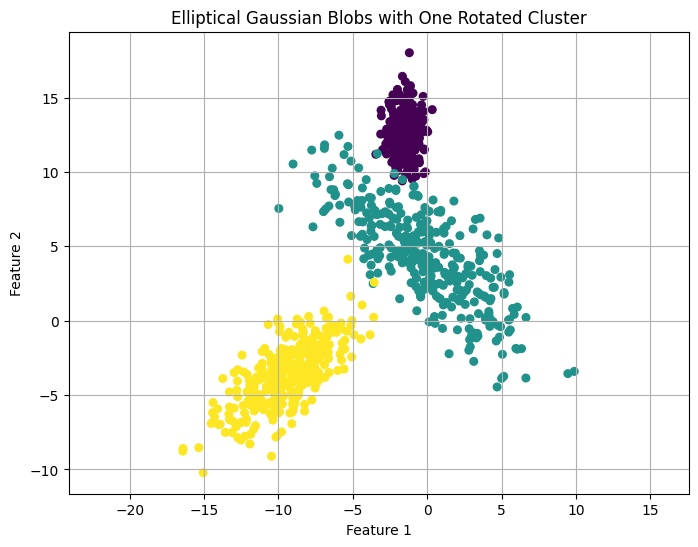

In [12]:
# GMM can be used for anomaly detection by defining a density threshold
# Any instance located in a low-density region can be considered an anomaly
# Let's begin by generating 3 elliptical blobs with rotation

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Set seed for reproducibility
np.random.seed(42)

# Generate a synthetic dataset of 3 Gaussian blobs in 2D
X, y_true = make_blobs(n_samples=1000,      # Total number of points
                       centers=3,           # Number of clusters
                       cluster_std=[1,3,2], # Standard deviation of each blob
                       n_features=2)        # Number of features (2D)

# Separate the points by cluster label
X0 = X[y_true == 0]  # Cluster 0
X1 = X[y_true == 1]  # Cluster 1
X2 = X[y_true == 2]  # Cluster 2

# Define a stretching transformation: makes blobs elliptical
stretch = np.array([
    [0.6, 0],    # Scale x-axis
    [0, 1.4]     # Scale y-axis
])

# Define a rotation matrix (45 degrees)
theta1 = np.radians(45)
rotation1 = np.array([
    [np.cos(theta1), -np.sin(theta1)],
    [np.sin(theta1),  np.cos(theta1)]
])

# Define a rotation matrix (45 degrees)
theta2 = np.radians(-45)
rotation2 = np.array([
    [np.cos(theta2), -np.sin(theta2)],
    [np.sin(theta2),  np.cos(theta2)]
])

# Apply transformations:
# - Stretch all clusters
# - Additionally rotate only cluster 1 (to show orientation difference)

X0_transformed = X0 @ stretch.T                        # Just stretched
X1_transformed = X1 @ (rotation1 @ stretch).T          # Rotated and stretched
X2_transformed = X2 @ (rotation2 @ stretch).T          # Rotated and stretched

# Combine all the transformed clusters into one dataset
X_elliptical = np.vstack((X0_transformed, X1_transformed, X2_transformed))

# Recreate the label array to match the new dataset
y_elliptical = np.hstack((
    np.zeros(len(X0)),        # Label 0
    np.ones(len(X1)),         # Label 1
    np.full(len(X2), 2)       # Label 2
))

# Plot the final dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_elliptical[:, 0], X_elliptical[:, 1],
            c=y_elliptical, cmap='viridis', s=30)

plt.title("Elliptical Gaussian Blobs with One Rotated Cluster")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.axis("equal")  # Keep aspect ratio square to show true shape
plt.show()

In [13]:
# Now we are going to train a GMM based on this dataset
# Import the GaussianMixture class for modeling from sklearn
from sklearn.mixture import GaussianMixture

# Suppress a specific warning from joblib about physical CPU cores
import warnings
warnings.filterwarnings("ignore", message="Could not find the number of physical cores")

# Create a Gaussian Mixture Model with 3 components and 10 initializations
# n_init=10 means the model will run 10 times with different initializations and pick the best
gm = GaussianMixture(n_components=3, n_init=10)

# Fit the model to the dataset X (which should be a 2D NumPy array of features)
gm.fit(X_elliptical)

# Print the weights (mixing proportions) of each Gaussian component
print(f"The weights of the model are: {gm.weights_}")

# Print the estimated means (centroids) of each component
print(f"The means of the model are: {gm.means_}")

# Print the estimated covariance matrices of each component
# These describe the shape and orientation of the Gaussian ellipses
print(f"The covariances of the model are: {gm.covariances_}")

The weights of the model are: [0.33248803 0.33615055 0.33136142]
The means of the model are: [[-0.13098181  4.25246322]
 [-1.51407622 12.57382119]
 [-9.5541573  -3.74956664]]
The covariances of the model are: [[[ 1.15841483e+01 -8.29826060e+00]
  [-8.29826060e+00  1.04303171e+01]]

 [[ 3.61300959e-01  6.13315146e-03]
  [ 6.13315146e-03  1.97032424e+00]]

 [[ 4.86704686e+00  3.22993494e+00]
  [ 3.22993494e+00  4.30865832e+00]]]


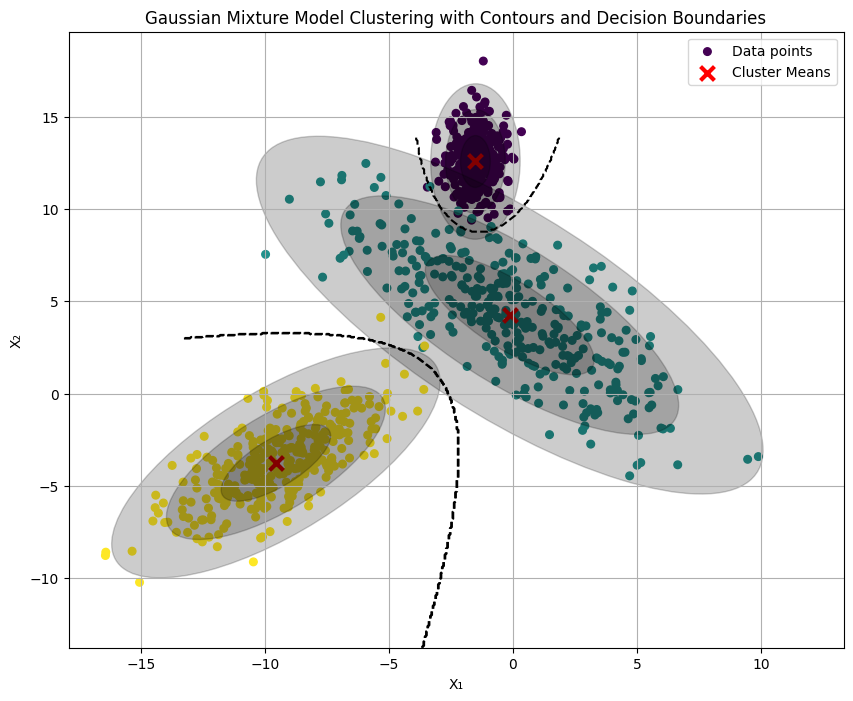

In [ ]:
# Let's visualize the dataset and the models means and covariance
from matplotlib.patches import Ellipse

# Create a meshgrid for decision boundaries
x = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 500)
y = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 500)
X_grid, Y_grid = np.meshgrid(x, y)
grid_points = np.c_[X_grid.ravel(), Y_grid.ravel()]

# Predict cluster labels for each point in the grid
Z = gm.predict(grid_points)
Z = Z.reshape(X_grid.shape)

# Plot
plt.figure(figsize=(10, 8))

# Plot decision boundaries (using predicted labels from the grid)
plt.contour(X_grid, Y_grid, Z, levels=np.unique(Z), colors='k', linestyles='dashed', linewidths=1.5)

# Plot data points
plt.scatter(X_elliptical[:, 0], X_elliptical[:, 1], c=y_elliptical, s=30, cmap='viridis', label='Data points')

# Plot the cluster means
plt.scatter(gm.means_[:, 0], gm.means_[:, 1], c='red', marker='x', s=100, linewidths=3, label='Cluster Means')

# Draw the ellipses for the Gaussian components
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance matrix."""
    ax = ax or plt.gca()

    if covariance.shape == (2, 2):  # Full covariance matrix
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:  # Diagonal covariance case
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    for nsig in range(1, 4):  # Draw 1σ, 2σ, 3σ ellipses
        ell = Ellipse(xy=position, width=nsig * width, height=nsig * height,
                      angle=angle, alpha=0.2, **kwargs)
        ax.add_patch(ell)

# Draw ellipses for each component
for mean, covar in zip(gm.means_, gm.covariances_):
    draw_ellipse(mean, covar, color='k')

plt.title("Gaussian Mixture Model Clustering with Contours and Decision Boundaries")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Next step is to determine a density threshold of 4% and find the anomalies

# Compute the log-density of each point under the fitted GMM
# (Higher scores = more likely under the model; lower = more anomalous)
densities = gm.score_samples(X_elliptical)

# Set a threshold at the 4th percentile: anything with a density lower than this
# is considered an anomaly (i.e., in the "tail" of the distribution)
density_threshold = np.percentile(densities, 4)

# Identify all points below the threshold as anomalies
anomalies = X_elliptical[densities < density_threshold]

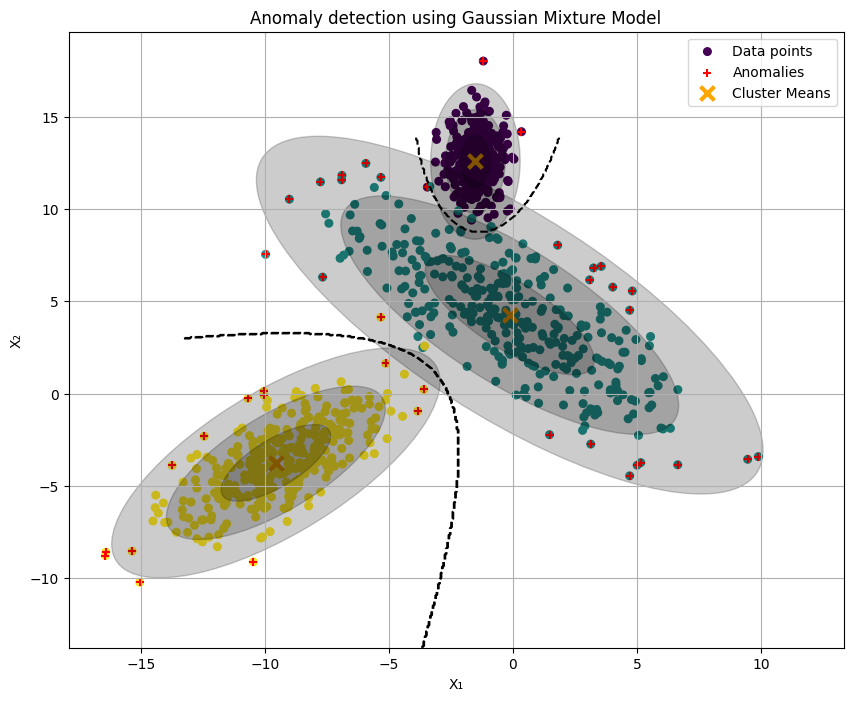

In [23]:
# Let's plot the results
plt.figure(figsize=(10, 8))

# Plot decision boundaries (using predicted labels from the grid)
plt.contour(X_grid, Y_grid, Z, levels=np.unique(Z), colors='k', linestyles='dashed', linewidths=1.5)

# Plot data points
plt.scatter(X_elliptical[:, 0], X_elliptical[:, 1], c=y_elliptical, s=30, cmap='viridis', label='Data points')

# Plot anomalies
plt.scatter(anomalies[:, 0], anomalies[:, 1], marker='+', c='red', s=30, label='Anomalies')

# Plot the cluster means
plt.scatter(gm.means_[:, 0], gm.means_[:, 1], c='orange', marker='x', s=100, linewidths=3, label='Cluster Means')

# Draw ellipses for each component
for mean, covar in zip(gm.means_, gm.covariances_):
    draw_ellipse(mean, covar, color='k')

plt.title("Anomaly detection using Gaussian Mixture Model")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.legend()
plt.grid(True)
plt.show()

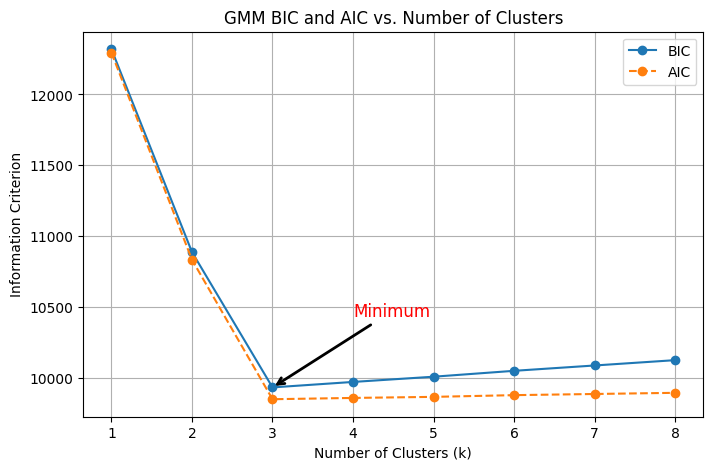

In [32]:
# As with the K-Means model, the number of clusters is an input for the model
# To determine the best number of clusters, we can use the likelihhod functions BIC and AIC

bic = []  # List to store BIC scores for each model
aic = []  # List to store AIC scores for each model

# Range of cluster counts to evaluate, from 1 to 8
k_values = range(1, 9)

# Loop through each number of components (clusters)
for k in k_values:
    # Initialize a Gaussian Mixture Model with k components
    model = GaussianMixture(n_components=k, n_init=10)
    
    # Fit the model to the elliptical dataset
    model.fit(X_elliptical)
    
    # Compute and store the BIC and AIC for this model
    bic.append(model.bic(X_elliptical))  # Bayesian Information Criterion
    aic.append(model.aic(X_elliptical))  # Akaike Information Criterion

# Plotting the BIC and AIC values to visually compare model complexity vs fit
plt.figure(figsize=(8, 5))
plt.plot(k_values, bic, marker='o', label="BIC")  # Solid line for BIC
plt.plot(k_values, aic, marker='o', linestyle='--', label="AIC")  # Dashed line for AIC

# Add labels and legend
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Information Criterion")
plt.legend()
plt.title("GMM BIC and AIC vs. Number of Clusters")
plt.grid(True)

# Highlight the minimum BIC value (typically best model)
plt.annotate("Minimum",
             xy=(3, bic[2]),                # Point (k=3, index 2 due to 0-based index)
             xytext=(4, bic[2] + 500),      # Position the text a bit above/right
             arrowprops=dict(arrowstyle="->", lw=2),  # Arrow pointing to min
             fontsize=12,
             color='red')

plt.show()